In [46]:
%load_ext autoreload
%autoreload 1

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import FileLink
import os
from IPython.display import clear_output, display

%aimport plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
use_dataset = True
selected_folder = 'Fishyscapes_LaF'
selected_file = '01_Hanns_Klemm_Str_45_000000_000260.png'
selected_model = 'grood_knn_e2e_cityscapes_500k_fl003_condensv5_randomcrop1344_hflip_nptest_lr0025wd54_ipdf0_ioodpdf0uni1_staticood1'
threshold = [0.9]

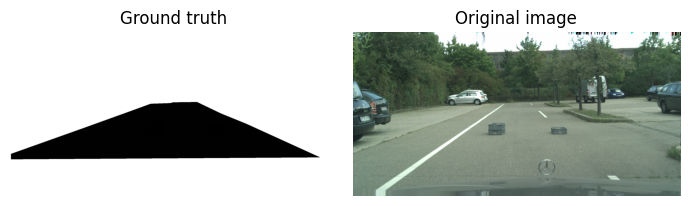

In [48]:
#Image preview
original_image, original_gt = plot.load_images(selected_file, use_dataset, selected_folder, selected_model)


fig, ax = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns, and adjust the figure size as needed

#mask_gray = cv.cvtColor(original_gt, cv.COLOR_BGR2GRAY)

# Display the mask
ax[0].imshow(original_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')  # Hide axes

# Display the image
ax[1].imshow(original_image)
ax[1].set_title('Original image')
ax[1].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [49]:
def show_image(original_image, original_gt, fig_size = (12,8)):   
    def process_images(use_dataset):
        original_image, original_gt = plot.load_images(selected_file, use_dataset, selected_folder, selected_model)
        contoured_image = plot.drawContours(original_image, original_gt, use_dataset, threshold)
        overlay_50 = plot.drawOverlay(0.5, original_image, original_gt, use_dataset, threshold)
        overlay_100 = plot.drawOverlay(1, original_image, original_gt, use_dataset, threshold)
        return np.concatenate((contoured_image, overlay_50, overlay_100), axis=1)
    
    first_row = process_images(True)
    second_row = process_images(False)

    # Stack the two rows vertically
    combined_image = np.concatenate((first_row, second_row), axis=0)
    clear_output(wait=True)
    
    # Display the combined image
    plt.figure(figsize=fig_size)
    plt.imshow(combined_image)
    plt.axis('off')
    plt.title('Contours and Overlays')
    plt.show()

    display(image_selector_widget, model_selector_widget, folder_selector_widget, slider)    

In [50]:
def on_folder_selected(change):
    global selected_folder
    selected_folder = change['new']
    print(f"Selected folder: {change['new']}")

    # Update the image selector options based on the selected folder
    image_selector_widget.options = plot.get_all_files(f'data/export/datasets/{selected_folder}/test/imgs/')


In [51]:
def on_model_selected(change):
    global selected_model
    selected_model = change['new']
    print(f"Selected model: {change['new']}")
    show_image(original_image, original_gt)

   
    #image_selector_widget.options = plot.get_all_files(f'data/export/datasets/{selected_folder}/test/imgs/')

In [52]:
def on_file_selected(change):
    global selected_file
    selected_file = change['new']
    print(f"Selected file: {selected_file}")

    # Call your function with the selected file name here
    original_image,original_gt = plot.load_images(selected_file, use_dataset, selected_folder, selected_model)
    show_image(original_image, original_gt)

In [53]:
def update_slider(thresh):
    threshold[0] = thresh
    show_image(original_image, original_gt)
    print(threshold[0])

BUG  
01_Hanns_Klemm_Str_45_000000_000230  
wrong ground truth

In [54]:
folder_selector_widget = widgets.Dropdown(
    options=plot.get_all_folders('data/export/datasets/'),  # Call the folder-only function
    description='Choose folder',
    disabled=False,
)
folder_selector_widget.observe(on_folder_selected, names='value')

image_selector_widget = widgets.Dropdown(
    options=plot.get_all_files('data/export/datasets/' + selected_folder + '/test/imgs/'),
    description='Choose file',
    disabled=False,
)
image_selector_widget.observe(on_file_selected, names='value')

model_selector_widget = widgets.Dropdown(
    options=plot.get_all_folders('data/export/results/'),
    description='Choose model',
    disabled=False,
)
model_selector_widget.observe(on_model_selected, names='value')



slider = widgets.FloatSlider(value=threshold[0], min=0, max=1, step=0.001, description='Threshold')
widgets.interactive(update_slider, thresh=slider)

#show_image(original_image, original_gt)


Dropdown(description='Choose file', index=2, options=('01_Hanns_Klemm_Str_45_000005_000230.png', '01_Hanns_Kle…

Dropdown(description='Choose model', index=1, options=('grood_logml_1000K_01adamw_tau10_resetthr1', 'grood_knn…

Dropdown(description='Choose folder', options=('RoadObstacles21', 'RoadAnomaly', 'RoadObstacles', 'Fishyscapes…

FloatSlider(value=0.9, description='Threshold', max=1.0, step=0.001)